# HW2: Local Planning

### EECE 5550: Mobile Robotics (Spring 2025)


**Collaboration Statement:**

In [ ]:
# I have collaborated with Gowtham and diccussed about some approaches for the solution of 1a and 1b.
#I collaborated with praddep surya dadi on some approaches to solve 1a

# Installation

This semester, we will use a custom simulator, called `gym-neu-racing`, to develop navigation algorithms. We implemented the basic structure of this simulator for you, and the HW assignments will ask you to implement important functions (e.g., kinematics, sensing, planning, mapping).

To install the simulator, you can use this command (it will download the latest code from GitLab and automatically install it in the environment your Colab notebook runs in):

In [ ]:
!pip install git+https://gitlab.com/neu-autonomy/gym-neu-racing.git

  Cloning https://gitlab.com/neu-autonomy/gym-neu-racing.git to /tmp/pip-req-build-0tjjeyx4
  Running command git clone --filter=blob:none --quiet https://gitlab.com/neu-autonomy/gym-neu-racing.git /tmp/pip-req-build-0tjjeyx4
  Resolved https://gitlab.com/neu-autonomy/gym-neu-racing.git to commit 60f6a0e80b5ae6dd14fb13a837c252d0d88fe571
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.7/12.7 MB 28.4 MB/s eta 0:00:00
  Created wheel for gym_neu_racing: filename=gym_neu_racing-0.0.1-py3-none-any.whl size=65573 sha256=83d1e922ec6a1f55913184a0840cc2f3de5c3624d9e5a6a0c2eb0c4230e6f4b3
  Stored in directory: /tmp/pip-ephem-wheel-cache-psal2c3r/wheels/4f/e1/e1/050619ec6014120d47555de901a265d190efdd96f993c95344
Successfully built gym_neu_racing


Now that the simulator and its dependencies have been installed, you can import the modules you'll need for this assignment:

In [ ]:
import gymnasium
import numpy as np
import gym_neu_racing
from gymnasium import spaces
from gym_neu_racing.envs.wrappers import StateFeedbackWrapper
import matplotlib.pyplot as plt
from typing import Callable
import matplotlib.cm as cmx
import matplotlib.colors as colors
from gym_neu_racing import motion_models
import cvxpy as cp

# Problem 1: MPPI

## 1a) MPPI to move toward a goal coordinate

In this problem, you'll implement a basic version of MPPI and show that it outputs a good rollout to move a robot toward a given goal position. This part uses the Unicycle kinematic model that's built into the simulator. You should  make sure that your `get_action` method considers the control limits (otherwise it may command things that the robot can't execute), which may require passing those as arguments to the `__init__` method.

You will probably need to experiment with different numbers of rollouts, cost functions, λ values, numbers of iterations, etc. to get good performance.

Keeping this code relatively organized and clean will help for later parts in the assignment, where you build on this implementation. For example, you are encouraged to define helper methods in your `MPPI` class to help keep your code organized (e.g., you may want a `score_rollouts` and/or `plot_rollouts` method that get called inside the `get_next_action` method).

**Deliverables**:
- Implement the `MPPI` class, in particular the `get_next_action` method, so that the chosen rollout drives the robot toward the goal position.
- Print the best control sequence your MPPI algorithm came up with (the first row/element of this sequence should be the action that your `get_action` returns)
- Include a plot that shows the rollouts, start position, goal position, and highlights the best rollout in that iteration, for at least a few iterations. We expect that the later iterations will give much better rollouts than the first iteration. You should make your axes have the same scale (e.g., using `plt.axis('equal')`).

In [ ]:
# Create an instance of the mobile robot simulator we'll use this semester
env = gymnasium.make("gym_neu_racing/NEUEmptyWorld-v0")

# Tell the simulator to directly provide the current state vector (no sensors yet)
env = StateFeedbackWrapper(env)

In [ ]:
class MPPI:
    def __init__(
        self,
        motion_model=motion_models.Unicycle(),
        control_limits=([0.0, -6.28], [1.0, 6.28]),
        num_rollouts=100,
        horizon=15,
        lambda_=0.15,
        iterations=3,
        noise_std=0.2,
    ):
        self.motion_model = motion_model
        self.control_limits = control_limits
        self.num_rollouts = num_rollouts
        self.horizon = horizon
        self.lambda_ = lambda_
        self.iterations = iterations
        self.noise_std = noise_std

    def get_action(self, initial_state: np.ndarray, goal_pos: np.ndarray):
        """ Compute the best action using MPPI """

        # Initialize the nominal control sequence
        u_bar = np.zeros((self.horizon, 2))

        for _ in range(self.iterations):

            # Generate noise
            delta_u = np.random.normal([0.3,0], [0.15,1], (self.num_rollouts, self.horizon, 2))

            scores = []
            rollouts = []

            for i in range(self.num_rollouts):
                rollout = [initial_state.copy()]  # To store rollout
                u = u_bar + delta_u[i]  # u_new = u_initial + delta_u
                u_clip = np.clip(u, self.control_limits[0], self.control_limits[1])

                curr_state = initial_state.copy()
                for j in range(self.horizon):
                    curr_state = self.motion_model.step(curr_state, u_clip[j])
                    rollout.append(curr_state)

                rollouts.append(rollout)
                scores.append(self.score_rollout(rollout, goal_pos))  # ✅ Fix here

            # Compute weights
            num = 0
            den = 0
            weight = np.exp((-1 / self.lambda_) * np.array(scores))

            for k in range(len(scores)):
                num += weight[k] * delta_u[k]  # ✅ Fix delta_u indexing
                den += weight[k]

            u_delta = num / den
            u_bar = u_bar + u_delta

            # Get the best rollout
            best_rollout_idx = np.argmin(scores)
            best_rollout = rollouts[best_rollout_idx]

        action = u_bar[0]  # Return the first action
        self.plot_rollouts(rollouts, best_rollout, goal_pos, initial_state)
        print("Best Action Sequence:", u_bar)
        return action

    def score_rollout(self, rollout, goal):
        """ Compute the cost of a rollout based on distance to the goal """
        rollout = np.array(rollout)  # ✅ Ensure it's a NumPy array
        gx, gy = goal  # ✅ Fix parameter name
        x_pos = rollout[:, 0]
        y_pos = rollout[:, 1]

        # Compute squared Euclidean distance
        score = np.sqrt((gx - x_pos)**2 + (gy - y_pos)**2)
        score = np.sum(score)

        return score

    def plot_rollouts(self, rollouts, best_rollout, goal_pos, initial_state):
          """
          Visualize the generated rollouts.
          """
          plt.figure(figsize=(5, 5))
          plt.scatter(initial_state[0], initial_state[1], color='green', label='Start')
          plt.scatter(goal_pos[0], goal_pos[1], color='red', label='Goal')
          plt.plot(initial_state[0], initial_state[1], 'go', markersize=10)
          plt.plot(goal_pos[0], goal_pos[1], 'ro', markersize=10)

          # Convert rollouts to array (handling list-of-lists issue)
          rollouts = np.array(rollouts, dtype=object)

          for traj in rollouts:
              traj = np.array(traj)  # Convert trajectory to NumPy array
              plt.plot(traj[:, 0], traj[:, 1], 'b-', alpha=0.3)

          # Plot the best rollout in red
          best_rollout = np.array(best_rollout)
          plt.plot(best_rollout[:, 0], best_rollout[:, 1], 'r-', linewidth=2, label='Best Rollout')

          plt.legend()
          plt.axis('equal')
          plt.show()

You can use the following code to check whether your MPPI implementation is working. After tuning your algorithm, it should be able to come up with a rollout that ends close to the goal (within 0.1m in l2 distance is close enough):

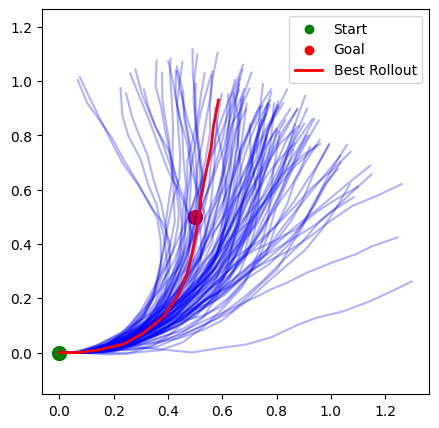

Best Action Sequence: [[ 0.83718853  2.16993886]
 [ 0.99358436  1.9910768 ]
 [ 0.99748468  2.01637495]
 [ 0.99642284  1.78512487]
 [ 0.89277468  1.59814452]
 [ 1.23877841  0.92487282]
 [ 0.81452605  2.00653083]
 [ 0.98648014  1.45442869]
 [ 0.63841016  0.26508047]
 [ 0.82265121  0.92623265]
 [ 0.86054777 -0.15953029]
 [ 0.95985279  0.67572778]
 [ 1.01097893 -0.40192256]
 [ 0.76194568 -0.66948823]
 [ 0.94287341 -0.20225183]]


In [ ]:
# Initialize the environment (and set random seed so any randomness is repeatable)
np.random.seed(0)
obs, _ = env.reset()

# Set the starting state (x, y, theta) and goal position (x, y).
initial_state = np.array([0.0, 0.0, 0.0])
goal_pos = np.array([0.5, 0.5])

# Instantiate your contoller class
controller = MPPI()

# Run your control algorithm for 1 step. We'll worry about running your
# algorithm in closed-loop in later parts of the assignment.
action = controller.get_action(initial_state, goal_pos)

## 1b) MPPI to drive around a racetrack

Now you will extend your MPPI implementation so that your robot drives around a racetrack. There are a few interesting challenges you'll need to figure out that didn't appear in the earlier problem:

*   How to score rollouts? Some possible ideas include placing waypoints around the track, designing a cost-to-go function, or encouraging the vehicle to maintain full speed, but this is completely up to you!
*   How to ensure the robot doesn't collide with the walls? You can transform coordinates from the world frame to map cell indices using `self.static_map.world_coordinates_to_map_indices(states_in_world)` and `self.static_map.static_map[map_indices]` to check whether a cell of the map is occupied or free.

**Deliverables**:
- Implement the `MPPIRacetrack` class below to enable your robot to complete a full lap around the track
- Generate a plot of the path taken with some indication of time (e.g., using a colorbar, timestamps every so often along the path, or another creative way you come up with)

In [ ]:
# Create an instance of the mobile robot simulator we'll use this semester
env = gymnasium.make("gym_neu_racing/NEURacing-v0")

# Tell the simulator to directly provide the current state vector (no sensors yet)
env = StateFeedbackWrapper(env)

In [ ]:
class MPPIRacetrack:
    def __init__(
        self,
        static_map,
        motion_model=motion_models.Unicycle(),
        control_limits=([0.0, -6.28], [1.0, 6.28]),
        horizon=10,
        num_rollouts=150,
        noise_std=1.5,
        lambda_=1,
        waypoints=([-4.0, 0.0],[-3.0, 2.5],[-1.0, 4.0], [0.0, 4.3],[1.0, 4.0],[2.0, 3.5],[3.0, 3.0], [4.0, 0.0], [0.0, -4.0]),
        iterations=1
    ):
        self.motion_model = motion_model
        self.static_map = static_map
        self.control_limits = control_limits
        self.horizon = horizon
        self.num_rollouts = num_rollouts
        self.noise_std = noise_std
        self.lambda_ = lambda_
        self.waypoints = waypoints[:]  # List of waypoints
        self.iterations = iterations

    def get_action(self, initial_state: np.ndarray):
        """ Compute the best action using MPPI """

        waypoints = np.array(self.waypoints)  # Use the class attribute
        # Initialize the nominal control sequence
        u_bar = np.zeros((self.horizon, 2))

        for _ in range(self.iterations):

            # Generate noise
            delta_u = np.random.normal([1,0], [self.noise_std, self.noise_std], (self.num_rollouts, self.horizon, 2))

            scores = []
            rollouts = []

            for i in range(self.num_rollouts):
                rollout = [initial_state.copy()]  # To store rollout
                u = u_bar + delta_u[i]  # u_new = u_initial + delta_u
                u_clip = np.clip(u, self.control_limits[0], self.control_limits[1])

                curr_state = initial_state.copy()
                for j in range(self.horizon):
                    curr_state = self.motion_model.step(curr_state, u_clip[j])
                    rollout.append(curr_state)

                rollouts.append(rollout)
                score, waypoints = self.score_rollout(rollout, waypoints)
                scores.append(score)

            # Update the class attribute with the new waypoints
            self.waypoints = waypoints.tolist()

            # Compute weights
            num = 0
            den = 0
            weight = np.exp((-1 / self.lambda_) * np.array(scores))

            for k in range(len(scores)):
                num += weight[k] * delta_u[k]
                den += weight[k]

            u_delta = num / den
            u_bar = u_bar + u_delta

            # Get the best rollout
            best_rollout_idx = np.argmin(scores)
            best_rollout = rollouts[best_rollout_idx]

        action = u_bar[0]  # Return the first action
        return action

    def score_rollout(self, rollout, waypoints):
        """ Compute the cost of a rollout based on distance to the goal """
        rollout = np.array(rollout)  # Ensure it's a NumPy array

        # Check if the rollout reaches near the current waypoint
        final_state = rollout[-1]
        distance_to_waypoint = np.linalg.norm(final_state[:2] - np.array(waypoints[0]))

        # Threshold distance to consider the waypoint reached
        waypoint_threshold = 1  # Adjust this value as needed

        if distance_to_waypoint < waypoint_threshold:
            # Update the waypoint to the next one in the list
            reached_waypoint = waypoints[0]
            waypoints = np.roll(waypoints, -1, axis=0)  # Cycle waypoints

        # Compute the cost based on the distance to the current waypoint
        gx, gy = waypoints[0]  # Use the updated waypoint
        x_pos = rollout[:, 0]
        y_pos = rollout[:, 1]

        # Compute squared Euclidean distance
        score = np.sqrt((gx - x_pos)**2 + (gy - y_pos)**2)
        score = np.sum(score)

        return score, waypoints

lap completed!
clockwise -> fwd lap completed
lap completed!
clockwise -> fwd lap completed
lap completed!
clockwise -> fwd lap completed


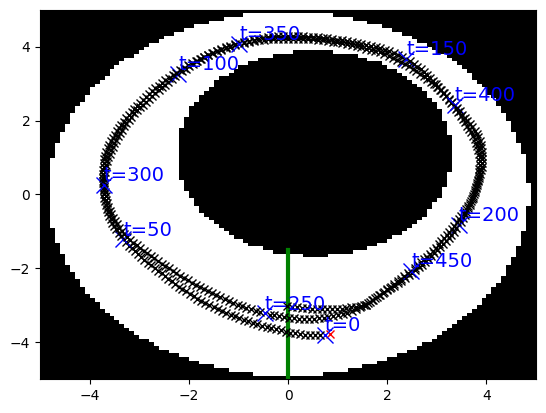

num timesteps used: 480


In [ ]:
def run_planner_on_racetrack(
    env: gymnasium.Env,
    planner_class=MPPIRacetrack,
    seed: int = 0,
    num_laps: int = 3,
) -> int:

    np.random.seed(seed)
    obs, _ = env.reset()
    env.unwrapped.laps_left = num_laps

    # Create an instance of your planner
    planner = planner_class(static_map=env.unwrapped.map)

    # Draw a map of the environment with the finish line + initial position
    ax = env.unwrapped.map.draw_map(show=False)
    ax.plot(
        env.unwrapped.finish_line[:, 0],
        env.unwrapped.finish_line[:, 1],
        "g",
        lw=3,
    )
    ax.plot(obs[0], obs[1], "rx")

    # Run the environment for num_timesteps, unless the robot hits an obstacle
    # or successfully completes the number of laps needed
    num_timesteps = 500
    success = False
    for t in range(num_timesteps):
        action = planner.get_action(obs)
        obs, _, terminated, _, _ = env.step(action)

        if t % 50 != 0:
            ax.plot(obs[0], obs[1], "kx")
        else:
            ax.plot(obs[0], obs[1], "bx", markersize=12)
            ax.text(obs[0], obs[1], f"t={t}", ha='left', va='bottom', fontsize=14, color='b')

        if terminated:
            success = True
            break

    num_timesteps_used = t

    plt.show()

    if success:
        return num_timesteps_used
    else:
        return -1


seed = 0
num_laps = 3
planner_class = MPPIRacetrack
num_timesteps_used = run_planner_on_racetrack(
    env, planner_class=planner_class, seed=seed, num_laps=num_laps
)
print(f"num timesteps used: {num_timesteps_used}")

## [Extra Credit] 1c) Compete for the fastest lap time

In this part, you can earn extra credit by achieving faster lap times (measured in average number of steps to complete the course, not computational runtime). You can get some extra credit by implementing a working version of something interesting here (e.g., another planning algorithm, a learning-based method, an extension beyond the basic MPPI we discussed in class). We will give additional extra credit to the student with the fastest lap time, which can be monitored on the Gradescope leaderboard.

In [ ]:
class BetterPlanner:
    def __init__(
        self,
        static_map,
        motion_model=motion_models.Unicycle(),
        control_limits=([0.0, -6.28], [1.0, 6.28]),
        horizon=9,
        num_rollouts=175,
        noise_std=1.8,
        lambda_=1,
        waypoints=([-4.0, 0.0],[-3.0, 2.5],[-1.0, 4.0], [0.0, 4.3],[1.0, 4.0],[2.5, 4.0],[2.6, 3.5], [3.0, 3.0], [4.0, 0.0], [0.0, -4.0]),
        iterations=1
    ):
        self.motion_model = motion_model
        self.static_map = static_map
        self.control_limits = control_limits
        self.horizon = horizon
        self.num_rollouts = num_rollouts
        self.noise_std = noise_std
        self.lambda_ = lambda_
        self.waypoints = waypoints[:]  # List of waypoints
        self.iterations = iterations

    def get_action(self, initial_state: np.ndarray):
        """ Compute the best action using MPPI """

        waypoints = np.array(self.waypoints)  # Use the class attribute
        # Initialize the nominal control sequence
        u_bar = np.zeros((self.horizon, 2))

        for _ in range(self.iterations):

            # Generate noise
            delta_u = np.random.normal([4.0,0], [self.noise_std, self.noise_std], (self.num_rollouts, self.horizon, 2))

            scores = []
            rollouts = []

            for i in range(self.num_rollouts):
                rollout = [initial_state.copy()]  # To store rollout
                u = u_bar + delta_u[i]  # u_new = u_initial + delta_u
                u_clip = np.clip(u, self.control_limits[0], self.control_limits[1])

                curr_state = initial_state.copy()
                for j in range(self.horizon):
                    curr_state = self.motion_model.step(curr_state, u_clip[j])
                    rollout.append(curr_state)

                rollouts.append(rollout)
                score, waypoints = self.score_rollout(rollout, waypoints)
                scores.append(score)

            # Update the class attribute with the new waypoints
            self.waypoints = waypoints.tolist()

            # Compute weights
            num = 0
            den = 0
            weight = np.exp((-1 / self.lambda_) * np.array(scores))

            for k in range(len(scores)):
                num += weight[k] * delta_u[k]
                den += weight[k]

            u_delta = num / den
            u_bar = u_bar + u_delta

            # Get the best rollout
            best_rollout_idx = np.argmin(scores)
            best_rollout = rollouts[best_rollout_idx]

        action = u_bar[0]  # Return the first action
        return action

    def score_rollout(self, rollout, waypoints):
        """ Compute the cost of a rollout based on distance to the goal """
        rollout = np.array(rollout)  # Ensure it's a NumPy array

        # Check if the rollout reaches near the current waypoint
        final_state = rollout[-1]
        distance_to_waypoint = np.linalg.norm(final_state[:2] - np.array(waypoints[0]))

        # Threshold distance to consider the waypoint reached
        waypoint_threshold = 1  # Adjust this value as needed

        if distance_to_waypoint < waypoint_threshold:
            # Update the waypoint to the next one in the list
            reached_waypoint = waypoints[0]
            waypoints = np.roll(waypoints, -1, axis=0)  # Cycle waypoints

        # Compute the cost based on the distance to the current waypoint
        gx, gy = waypoints[0]  # Use the updated waypoint
        x_pos = rollout[:, 0]
        y_pos = rollout[:, 1]

        # Compute squared Euclidean distance
        score = np.sqrt((gx - x_pos)**2 + (gy - y_pos)**2)
        score = np.sum(score)

        return score, waypoints

lap completed!
clockwise -> fwd lap completed
lap completed!
clockwise -> fwd lap completed
lap completed!
clockwise -> fwd lap completed


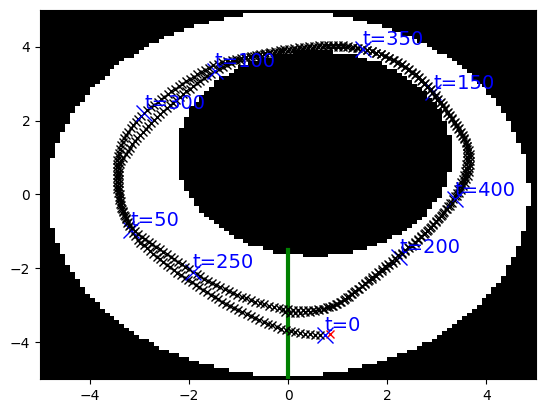

448

In [ ]:
seed = 0
num_laps = 3
planner_class = BetterPlanner
run_planner_on_racetrack(
    env, planner_class=planner_class, seed=seed, num_laps=num_laps
)

# Problem 2: Trajectory Optimization with `cvxpy`

## 2a) Double Integrator: Initial & Terminal Conditions

For this problem, you'll use the 2D discrete-time double integrator dynamics, where $$\mathbf{x}[t] = \begin{bmatrix}
x[t]\\
y[t]\\
v_x[t]\\
v_y[t]\\
\end{bmatrix}, \quad \mathbf{u}[t] = \begin{bmatrix} a_x[t]\\ a_y[t]\\ \end{bmatrix}, \quad \mathbf{x}[t+dt] = A \mathbf{x}[t] +  B \mathbf{u}[t], \quad A = \begin{bmatrix}
1 & 0 & dt & 0 \\
0 & 1 & 0 & dt \\
0 & 0 & 1 & 0 \\
0 & 0 & 0 & 1 \\
\end{bmatrix}, \quad B = \begin{bmatrix}
\frac{dt^2}{2} & 0 \\
0 & \frac{dt^2}{2} \\
dt & 0 \\
0 & dt \\
\end{bmatrix}.
$$

You should turn the following optimization problem into code:

$$
\begin{align}
\min_{x_{0:T}, u_{0:T}}\quad & (x[T] - g_x)^2 + (y[T] - g_y)^2 \\
\text{s.t.}\quad & \mathbf{x}[t+1] = A \mathbf{x}[t] + B \mathbf{u}[t] \quad \forall t \in \{0, 1, \ldots, T-1\} \\
& \mathbf{u}[t] \in U \quad \forall t \in \{0, 1, \ldots, T-1\} \\
& \mathbf{x}[0] = \mathbf{x}_0 \\
& v_x[T] = v_{x,T} \\
& v_x[T] = v_{y,T} \\
\end{align}
$$

with $g_x = 3, g_y=5, v_{x,T}=0, v_{y,T}=0, \mathbf{x}_0 = [1, 2, 0, 0], U = [-1, 1] \times [-1, 1], T=10$.

**Deliverables**:
- Implement `optimize_trajectory`, which will take in initial and terminal conditions, control limits, dt, and return the optimal sequence of states (i.e., an array of shape (T+1, 4) -- T+1 timesteps (T timesteps + the initial state) and 4 states per timestep)
- Generate a plot of your optimal trajectory. You are welcome to use the `plot_trajectory` function or write your own version.

In [ ]:
def optimize_trajectory(
    initial_pos: np.ndarray,
    initial_vel: np.ndarray,
    goal_pos: np.ndarray,
    goal_vel: np.ndarray,
    u_limits: np.ndarray,
    dt: float,
) -> np.ndarray:
    """ Your implementation here"""

    T = 10
    N = int(T/dt) + 1

    # Initializing the matrices
    A = np.array([[1, 0, dt, 0],
                    [0, 1, 0, dt],
                    [0, 0, 1,  0],
                    [0, 0, 0,  1]])

    B = np.array([[(dt**2)/2, 0],
                    [0, (dt**2)/2],
                    [dt,        0],
                    [0,        dt]])

    # Declaring the state variable X and control variable U
    X = cp.Variable((4,N+1))
    U = cp.Variable((2,N+1))

    # Initializing the intial state and the final state
    X_0 = np.array([initial_pos[0],initial_pos[1],initial_vel[0],initial_vel[1]])
    X_t = np.array([goal_pos[0],goal_pos[1],goal_vel[0],goal_vel[1]])

    # Adding the control constraints
    constraints = [U[0] >= u_limits[0][0], U[0] <= u_limits[0][1], U[1] >= u_limits[1][0], U[1] <= u_limits[1][1], X[:,0] == X_0]

    # for t in range(N):
    #   X_current = (A @ X[:,t]) + (B @ U)
    #   cost = ((goal_pos[0] - X[0,t])**2) + ((goal_pos[1] - X[1,t])**2)
    #   # cost = cp.sum_squares(X_t - X_current)
    #   prob = cp.Problem(cp.Minimize(cost),constraints)
    #   prob.solve()
    #   # print(X_current)
    #   print("U: ", U.value)
    #   print("X: ",X_current)
    #   X[:,t+1] = X_current.value

    # Adding each state as dictated by the dynamics as a constraint
    for t in range(N):
      constraints += [X[:,t+1] == (A @ X[:,t]) + (B @ U[:,t])]

    # Adding the final state constraint
    constraints += [X[:,-1] == X_t]

    # Declaring the cost function and objective
    cost = cp.sum_squares(X[0:2] - goal_pos[:,None])
    prob = cp.Problem(cp.Minimize(cost),constraints)

    # Solving for the variables
    prob.solve()

    # raise NotImplementedError
    return np.transpose(np.array(X.value))


def plot_trajectory(xt: np.ndarray) -> None:

    # Feel free to add to this

    plt.plot(xt[:, 0], xt[:, 1], "-x")
    plt.axis("equal")
    plt.show()


You can check whether your code works using

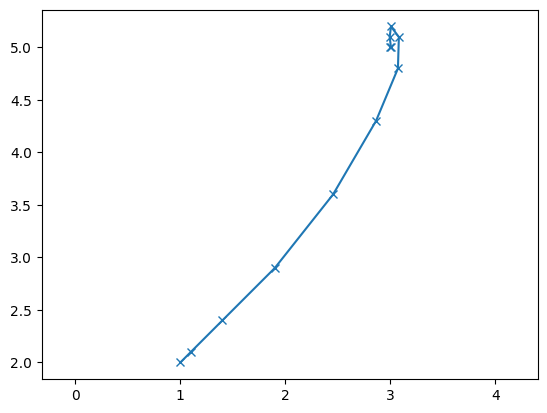

In [ ]:
initial_pos = np.array([1.0, 2.0])
initial_vel = np.array([0.0, 0.0])
goal_pos = np.array([3.0, 5.0])
goal_vel = np.array([0.0, 0.0])
u_limits = 0.2 * np.array([[-1.0, 1.0], [-1.0, 1.0]])
dt = 1.0

optimal_xt = optimize_trajectory(
    initial_pos,
    initial_vel,
    goal_pos,
    goal_vel,
    u_limits,
    dt,
)

plot_trajectory(optimal_xt)

## [Extra Credit] 2b) Incorporate obstacle avoidance as a convex optimization problem

Now, you should extend your optimization code to handle a list of circular obstacles that the double integrator must avoid. We would like you to try to keep this as a convex optimization problem. If you just start adding constraints and costs, you will likely end up with a non-convex optimization problem, which are generally hard to solve.

One possible way to keep the problem convex could be to break the free (i.e., non-obstacle) space into a set of convex regions, then split the trajectory into multiple segments (each one needing to stay within one convex region). But, there could be many other ways, and you are encouraged to try different strategies!


In [ ]:
def optimize_trajectory_with_obstacles(
    initial_pos: np.ndarray,
    initial_vel: np.ndarray,
    goal_pos: np.ndarray,
    goal_vel: np.ndarray,
    u_limits: np.ndarray,
    dt: float,
    obstacles: list,
) -> np.ndarray:

    """ Your implementation here"""
    raise NotImplementedError
    return states


def plot_trajectory_with_obstacles(
    xt: np.ndarray,
    obstacles: list[np.ndarray],
) -> None:

    # Feel free to add to this

    fig, ax = plt.subplots()
    plt.plot(xt[:, 0], xt[:, 1], "-x")
    for obstacle in obstacles:
        ax.add_patch(plt.Circle(obstacle[0:2], obstacle[2], color="r"))
    plt.axis("equal")
    plt.show()

In [ ]:
initial_pos = np.array([1.0, 2.0])
initial_vel = np.array([0.0, 0.0])
goal_pos = np.array([3.0, 5.0])
goal_vel = np.array([0.0, 0.0])
u_limits = 0.2 * np.array([[-1.0, 1.0], [-1.0, 1.0]])
dt = 1.0

obstacles = [
    (1.5, 2.5, 0.5),
    (2.0, 3.5, 0.25),
    (2.5, 4.0, 0.5),
]

optimal_xt = optimize_trajectory_with_obstacles(
    initial_pos,
    initial_vel,
    goal_pos,
    goal_vel,
    u_limits,
    dt,
    obstacles,
)

plot_trajectory_with_obstacles(optimal_xt, obstacles)

NotImplementedError: 